# Grid Cells

The goal of this notebook is to understand the topology of the population activity of a module of grid cells.

<video controls width="400" src="figures/population_experiments.mp4" />

- Gardner, R.J., Hermansen, E., Pachitariu, M. et al. _Toroidal topology of population activity in grid cells._ **Nature** 602, 123–128 (2022).

**Grid cells** are neurons present in rats and other mammals (including hummans) that constitute a positioning system in the brain, encoding a neural representation of a metric in the 2-dimensional space. The arrangement of each grid cell's spatial firing fields, all at equal distances from their neighbours, forms an hexagonal pattern as discovered by Edvard Moser and May-Britt Moser, who were awarded the 2014 Nobel Prize in Physiology or Medicine for their work.

<video controls src="figures/grid_cells.mp4" />

## Point cloud

We import the data (available at https://figshare.com/articles/dataset/Toroidal_topology_of_population_activity_in_grid_cells/16764508)

In [3]:
import numpy as np
data = np.load('data/rat_r_day1_grid_modules_1_2_3.npz', allow_pickle=True)

In [4]:
data.files

['spikes_mod1', 'spikes_mod2', 'spikes_mod3', 'x', 'y', 't', 'z', 'azimuth']

### Position

We select the part of the session when the rat is moving in an open field.

In [5]:
#open_field_1, start=7457, end=16045, valid_times=[7457,14778;14890,16045]
start1= 7457.01
end1  = 14778.00
tmin1 = int((start1-data['t'].min())*100)
tmax1 = int((end1-data['t'].min())*100)
start2= 14890.01
end2  = 16045.00
tmin2 = int((start2-data['t'].min())*100)
tmax2 = int((end2-data['t'].min())*100)

In [6]:
positions = np.column_stack([data['x'][np.r_[tmin1:tmax1, tmin2:tmax2]], data['y'][np.r_[tmin1:tmax1, tmin2:tmax2]]])

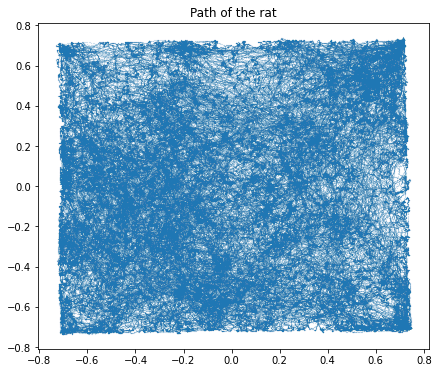

In [7]:
import pylab as plt
plt.figure(figsize = (7,6))
plt.scatter(data['x'][np.r_[tmin1:tmax1, tmin2:tmax2]], data['y'][np.r_[tmin1:tmax1, tmin2:tmax2]], s = 0.005)
plt.title('Path of the rat');

### Firing rates (module 1)

We first compute (linearly infer) the position of the rat at the firing times.

In [8]:
def linear_combination(data_pos, data_spikes, index0, t0, delta_t):
    n = len(index0)
    index1 = [int(x) for x in index0 + np.ones(n)]
    v = (data_pos[index1]-data_pos[index0])/delta_t * (data_spikes-t0) + data_pos[index0]
    return v

mod = data['spikes_mod1'].item()
pos = {}
tmin = data['t'].min()

for cell, spikes in mod.items():
    spikes = mod[cell]
    openfield = spikes[np.logical_or((spikes<end1) & (spikes>start1), (spikes<end2) & (spikes>start2))]
    nspikes = len(openfield)
    pos[cell] = np.zeros((2, nspikes))
    t0 = np.floor(openfield*100)/100 #2 decimals
    index0 = [int(x) for x in np.floor((t0-tmin)*100)]
    pos[cell][0] = linear_combination(data['x'], openfield, index0, t0, 0.01)
    pos[cell][1] = linear_combination(data['y'], openfield, index0, t0, 0.01)

We the compute the firing rate maps

In [9]:
from scipy.ndimage import gaussian_filter

def discretize(cell_dgm, m=0, M=1, res=30, filt=None, sigma=0.5):
    '''
    Discretize one cell map, returns a 2D-histogram of size (res x res), the grid representing [m, M]^2.
    '''
    h2d = np.histogram2d(cell_dgm[0,:], cell_dgm[1,:], bins=res, range=[[m, M],[m, M]])[0]
    h2d = np.flip(h2d.T, axis=0)
    if filt=="gaussian":
        h2d = gaussian_filter(h2d, sigma=sigma)
    return h2d

n_bins = 30
l0 = -0.725
l1 = 0.725
smooth_positions = discretize(positions.T,l0, l1, n_bins, "gaussian", 1)
fire_rate_grid = {}
for cell in pos.keys():
    fire_rate = discretize(pos[cell], l0, l1, n_bins, "gaussian", 1)
    fire_rate_grid[cell] = (fire_rate/smooth_positions).flatten()

We now plot the firing rate maps for the cells in module 1.

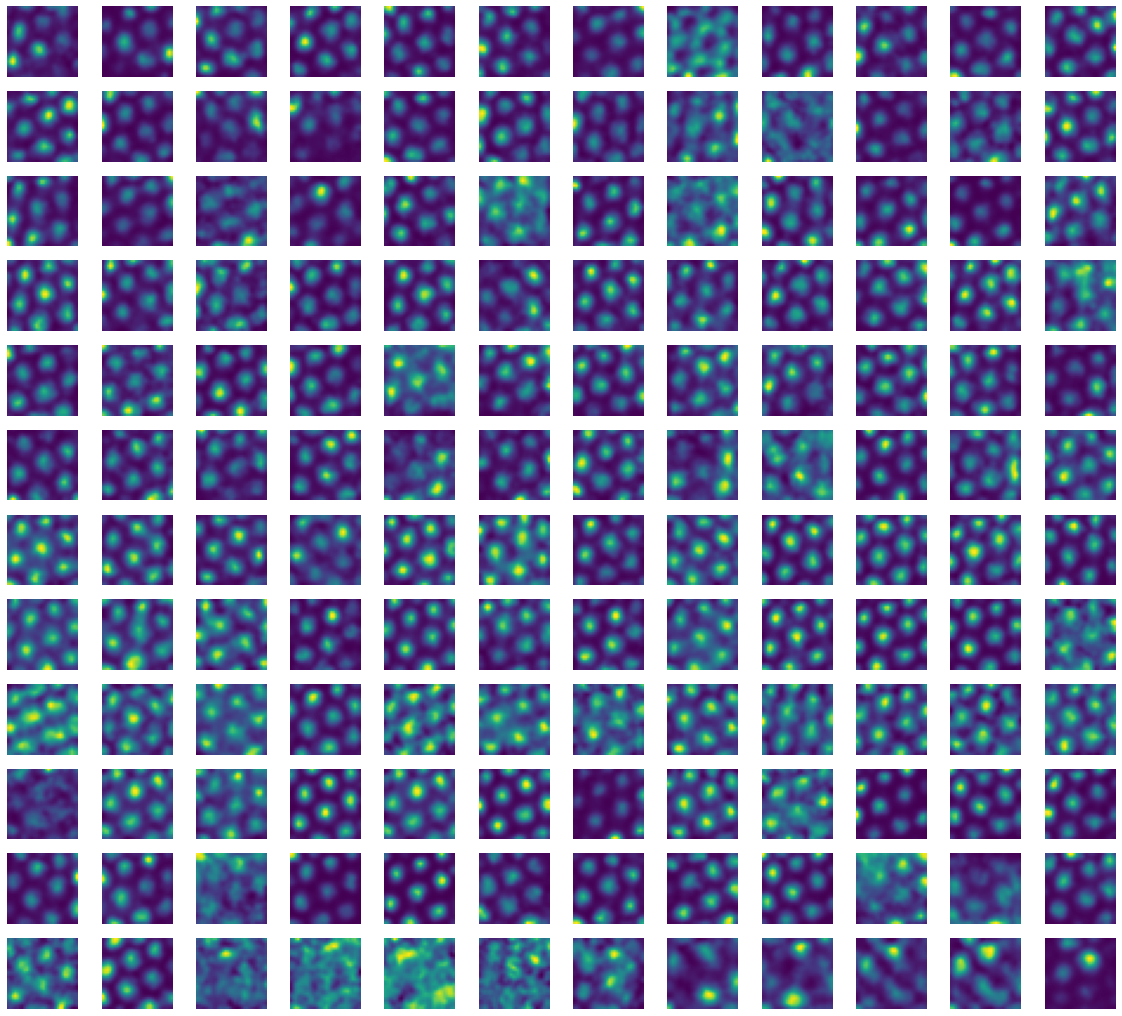

In [10]:
import pylab as plt

fig = plt.figure(figsize = (20,20))

for i in list(fire_rate_grid.keys())[:144]:
    plt.subplot(13,12,1+i)
    plt.axis('off')
    plt.imshow(fire_rate_grid[i].reshape(30,30))

### Geometry of neural activity

In [58]:
#!pip install fermat
from fermat import Fermat
from scipy.spatial import distance_matrix

def compute_distance(data,k):
    '''
    Computes the  estimator of geodesic distance of the algorithm ISOMAP.
    '''
    distances = distance_matrix(data,data)
    f_aprox_D = Fermat(1, path_method='D', k=k) 
    f_aprox_D.fit(distances)
    adj_dist = f_aprox_D.get_distances() 

    return adj_dist

In [59]:
population_data = np.array(list(fire_rate_grid.values())).T
population_data.shape

(900, 166)

In [60]:
np.savetxt('data/grid_cells.txt', population_data)

In [61]:
distance_matrix = compute_distance(population_data, 15)
distance_matrix.shape

(900, 900)

In [64]:
distance_matrix.max()

2.0216479790467092

In [62]:
np.savetxt('data/dmatrix_grid_cells.txt', distance_matrix)

In [40]:
from sklearn.manifold import MDS
embedding = MDS(n_components=3, dissimilarity='precomputed', random_state = 123)
embedding_data = embedding.fit_transform(distance_matrix)

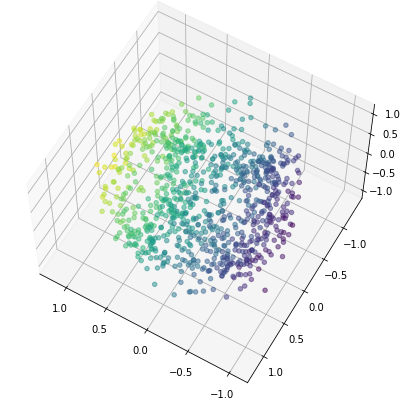

In [39]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter(
    embedding_data[:,0],
    embedding_data[:,1],
    embedding_data[:,2], alpha = 0.5, c = embedding_data[:,0], s = 20)
angle1, angle2 = 60,120
ax.view_init(angle1, angle2)
plt.show()

### Persistent Homology

In [44]:
from ripser import Rips
rips = Rips(maxdim = 2)
dgms = rips.fit_transform(distance_matrix, distance_matrix=True)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


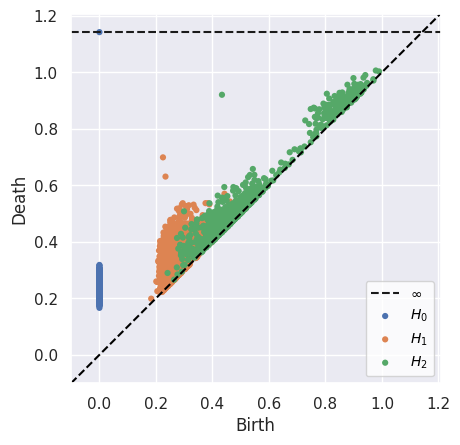

In [66]:
import seaborn as sns
sns.set()
rips.plot(dgms)